### Helper Classes

First we get all of our helper modules. The prepare_EMG module will prepare the EMG data for phoneme recognition. The prepare_outputs module will prepare our target labels and align them with our EMG data. The module 'prepare_data' will help us read data from CSV into a dataframe. Finally, 'vis' will help visualize EMG data in both time and frequency domains. 

In [89]:
%load_ext autoreload
%autoreload 2

import prepare_EMG, prepare_outputs, prepare_data, vis, pandas
# autodetector = Output_Prep.detector
EMG_Prep = prepare_EMG.EMG_preparer()
# Output_Prep = prepare_outputs.output_preparer(subvocal_detector = autodetector, window_size=30.0)
Output_Prep = prepare_outputs.output_preparer()

Data_Prep = prepare_data.data_preparer()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
singles = Data_Prep.load_singletons(1)
print(singles.keys())

File b'simple-svr-data/raspy-1' does not exist
dict_keys(['dusty', 'march', 'direful', 'complete', 'superb', 'poised', 'wait', 'quaint', 'save', 'copy', 'interest', 'separate', 'bright', 'utter', 'bored', 'nondescript', 'license', 'vest', 'dance', 'money', 'languid', 'swim', 'enthusiastic', 'quartz', 'planes', 'spiritual', 'imperfect', 'coal', 'hobbies', 'sound', 'bow', 'squirrel', 'push', 'treatment', 'mine', 'precede', 'weather', 'amazing', 'round', 'stingy', 'signal', 'marry', 'country', 'uncle', 'dust', 'certain', 'loose', 'knock', 'advice', 'confuse', 'animated', 'loving', 'feeling', 'absorbing', 'trick', 'spare', 'rod', 'caption', 'throne', 'clumsy', 'vague', 'tow', 'hang', 'rely', 'tired', 'barbarous', 'pan', 'innocent', 'combative', 'low', 'rub', 'mixed', 'actually', 'faulty', 'thirsty', 'dam', 'doubtful', 'flowers', 'defective', 'frogs', 'outstanding', 'ducks', 'icicle', 'fry', 'load', 'cracker', 'efficient', 'hop', 'fax', 'fancy', 'reading', 'real', 'addicted', 'motion', 'cle

### Labeling the Data

First, we generate the phoneme and articulatory feature labels from each word. We'll use these to process the data in each file based on the length of the file and how many phonemes it should contain. We scale the FFT windows relative to the length of time we expect an even distribution of phonemes across the file to have. 

In [91]:
from scipy import signal
import numpy as np


labels = {}
windows = {}
for word in singles:
    label = Output_Prep.transform(word)
    num_phonemes = label.shape[0]
    labels[word] = label
    widths = np.linspace(0.01,10,50)
    wt_out = signal.cwt(singles[word]['voltage'], signal.ricker, widths)
    wt_out = pandas.DataFrame(wt_out).T
    windows[word] = EMG_Prep.process(wt_out, num_phonemes, wavelets=True)




In [93]:
print(windows['save'], labels['save'])


    0           1          2          3          4          5           6   \
0  0.0  125.160137  60.688780  49.024103  75.597840  94.327163  109.610647   
1  0.0  130.939707  63.378938  49.553915  77.065729  96.477274  113.066130   
2  0.0  131.205315  63.362674  49.969662  77.708119  96.133031  111.177257   

           7           8           9     ...             40         41  \
0  120.307162  129.520285  139.926345    ...      72.140220  71.652170   
1  125.806055  136.554054  147.425087    ...      57.918683  57.100783   
2  121.803574  130.905249  139.191905    ...      54.494655  54.270163   

          42         43         44         45         46         47  \
0  71.054469  70.420228  69.721071  69.003278  68.300877  67.553393   
1  56.233521  55.334149  54.426799  53.511268  52.576652  51.604704   
2  54.060772  53.840377  53.621448  53.394984  53.164332  52.975235   

          48         49  
0  66.861010  66.147867  
1  50.637542  49.725733  
2  52.904278  52.860421  



In [4]:
test_word = 'license'
test_word2 = 'money'
test_EMG = windows[test_word]
test_EMG2 = windows[test_word2]

print(test_EMG.head(6), labels[test_word], test_EMG2.head(), labels[test_word2])

       0.0       10.0      10.0      20.0      20.0      30.0      30.0   \
0  43.492969  0.020570  2.259229  1.954676  1.681519  1.445389  2.413685   
1  47.746875  2.017764  0.095421  0.633403  0.322932  2.490014  1.047570   
2  43.325391  1.125540  0.838279  0.147355  0.309692  0.321898  0.573655   
3  42.680859  1.142250  0.402145  1.505252  0.509298  0.329306  0.888195   
4  44.421094  0.062747  1.107197  0.216720  0.385406  1.835386  1.378310   
5  44.098828  0.190692  0.318395  1.432442  0.888541  0.892307  0.651676   

      40.0      40.0      50.0     ...        450.0     460.0     460.0  \
0  0.423931  1.066141  1.716362    ...     0.394087  0.043894  0.195630   
1  0.822770  4.314441  0.909039    ...     0.924509  0.736296  1.002601   
2  4.172037  2.061649  0.181364    ...     1.295144  0.545687  1.338983   
3  1.115764  2.908927  1.167312    ...     0.145217  0.530457  0.348105   
4  1.094253  2.286328  0.503626    ...     0.123156  2.375713  1.121218   
5  2.017346  2.06

In [94]:
import pandas
%autoreload 2

# num_files = len(data_list)
# labels_frame = pandas.read_csv('austen_subvocal.csv')
# trans_labels = Output_Prep.transform(labels_frame.iloc[0][0])
# data_1_proc = EMG_Prep.process(data_1)
# aligned_data, trans_labels= Output_Prep.zip(data_1_proc, trans_labels, repeat=3)

# for file in range(1, num_files):
#     trans_labels_iter = Output_Prep.transform(labels_frame.iloc[file][0])
#     data_proc_iter = EMG_Prep.process(data_list[file])
#     aligned_data_iter, trans_labels_iter = Output_Prep.zip(data_proc_iter, trans_labels_iter, repeat=3)

#     aligned_data = aligned_data.append(aligned_data_iter)
#     trans_labels = trans_labels.append(trans_labels_iter)
    
# print('Aligned Data shape:',aligned_data.shape,'Trans labels shape:',trans_labels.shape)
y = pandas.DataFrame()
X = pandas.DataFrame()
for word in labels:
#     append labels to the master label dataframe
    label_frame = labels[word]
    y = y.append(label_frame)
#     Use phonemes to name each series in 'windows' for that word
    window_frame = windows[word]
    if len(label_frame.axes[0]):
        window_frame = window_frame.rename_axis(lambda x: label_frame.axes[0][x])
        X = X.append(window_frame)
    else:
        print('no labels for:',word)

#     for row in range(label_frame.shape[0]):
        
#         new_row = pandas.Series(window_frame.iloc[row])
#         new_row.name = label_frame.iloc[row].name
#         X = X.append(new_row)
#     Append windows to a master window dataframe
# X = X.rename_axis(list(zip(X.axes[0],y.axes[0])))

no labels for: direful
no labels for: wrathful


In [95]:
# print(X.head(18), y.head(18))
from sklearn.preprocessing import scale,normalize
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=9)
X_reduced = pca.fit_transform(X)
X_scaled = scale(X_reduced)
X_normalized = normalize(X_scaled)

X_normalized = pandas.DataFrame(X_normalized)
X_normalized = X_normalized.rename_axis(lambda x: 'pc-'+str(x), axis='columns')
print(X_normalized)


         pc-0      pc-1      pc-2      pc-3      pc-4      pc-5      pc-6  \
0    0.165676 -0.262812  0.098190 -0.046712  0.350128  0.228535  0.391418   
1    0.136320 -0.314732  0.141591 -0.209032  0.208326 -0.245301  0.049617   
2    0.202402 -0.094556  0.363611  0.282489  0.206000 -0.655711 -0.010915   
3    0.188516 -0.132501  0.283670 -0.109947  0.030988  0.111221  0.278311   
4    0.324947  0.313151 -0.369247 -0.036077 -0.075749 -0.657799  0.237141   
5    0.556920  0.118943  0.199309  0.255547  0.340396 -0.169273  0.494641   
6    0.512543  0.426669  0.295492 -0.186147 -0.009987 -0.605766  0.103846   
7    0.536817  0.284763  0.170993 -0.182669  0.040173 -0.511347  0.268116   
8    0.473507 -0.199387 -0.077968 -0.020593 -0.160003 -0.305226  0.707486   
9    0.091723  0.100324 -0.297035  0.197333  0.212847 -0.039013  0.476551   
10   0.149217 -0.082920 -0.141449  0.025969 -0.227968  0.145201  0.845830   
11   0.139693 -0.249156  0.029780  0.027002 -0.250114 -0.225393  0.853986   

### AF Extractor Models

These models will be optimized for extracting AF's from the data, before passing those AF's onto an MLPC for identifying the most likely phoneme. 

In [96]:
# Prepare lists of parameters for our GridSearch
# First, our layer sizes
layer_sizes = []
for i in range(2,5):
    for j in range(0,180,30):
        if j:
            tup = []
            for k in range(i):
                tup.append(j)
            layer_sizes.append(tuple(tup))
print('number layer sizes:',len(layer_sizes),'here be layer sizes',layer_sizes)

# Next, our alpha values
alphas = [0.0001,1,1000]

number layer sizes: 15 here be layer sizes [(30, 30), (60, 60), (90, 90), (120, 120), (150, 150), (30, 30, 30), (60, 60, 60), (90, 90, 90), (120, 120, 120), (150, 150, 150), (30, 30, 30, 30), (60, 60, 60, 60), (90, 90, 90, 90), (120, 120, 120, 120), (150, 150, 150, 150)]


### Preparing GridSearch and Assesing Stock MLPC as AF extractor models

We setup the objects for performing gridsearch on each one of the Articulatory Feature Extractor models. We also train untuned, stock MLPC models to serve as a performance baseline. We will compare the performance of these baseline, untuned models to our gridsearched models to determine whether gridsearch has in fact improved the model parameters for each AF extractor. 

In [97]:
from sklearn.neural_network import MLPClassifier as MLPC
# Import other models to try for feature extraction
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

import copy

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.15, random_state=12)

combined_features = FeatureUnion([
    ('pca',PCA(random_state=18)),
    ('kbest',SelectKBest(k=1))
])

pipeline = Pipeline([
#     ('features', combined_features),
    ('model', MLPC(random_state=12))
])


param_grid = {
#     'features__pca__n_components':[10,20,50],
    'model__solver':['adam'],
    'model__hidden_layer_sizes':layer_sizes,
    'model__activation':['relu'],
    'model__alpha': alphas,
    'model__max_iter':[200]
}


grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1)

manner_classifier = MLPC(solver='adam',random_state=3)
manner_classifier.fit(X_train, y_train['manner'])
m_score = manner_classifier.score(X_test, y_test['manner'])

place_classifier = MLPC(solver='adam',random_state=6)
place_classifier.fit(X_train, y_train['place'])
p_score = place_classifier.score(X_test, y_test['place'])

height_classifier = MLPC(solver='adam',random_state=9)
height_classifier.fit(X_train, y_train['height'])
h_score = height_classifier.score(X_test, y_test['height'])

vowel_classifier = MLPC(solver='adam',random_state=12)
vowel_classifier.fit(X_train, y_train['vowel'])
v_score = vowel_classifier.score(X_test, y_test['vowel'])

print('manner score:',m_score,'place score:',p_score,'height score:',h_score,'vowel score:',v_score)
# print(data_1_proc.head(50), trans_labels['manner'].head(50))

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


manner score: 0.294642857143 place score: 0.258928571429 height score: 0.482142857143 vowel score: 0.616071428571


In [129]:
manner_classifier2 = copy.deepcopy(grid_search)
manner_classifier2.fit(X_train, y_train['manner'])
m_score2 = manner_classifier2.score(X_test, y_test['manner'])

print('manner score:',m_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

manner score: 0.375


In [130]:
place_classifier2 = copy.deepcopy(grid_search)
place_classifier2.fit(X_train, y_train['place'])
p_score2 = place_classifier2.score(X_test, y_test['place'])

print('place score:',p_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

place score: 0.276785714286


In [131]:
height_classifier2 = copy.deepcopy(grid_search)
height_classifier2.fit(X_train, y_train['height'])
h_score2 = height_classifier2.score(X_test, y_test['height'])

print('height score:',h_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

height score: 0.473214285714


In [132]:
vowel_classifier2 = copy.deepcopy(grid_search)
vowel_classifier2.fit(X_train, y_train['vowel'])
v_score2 = vowel_classifier2.score(X_test, y_test['vowel'])

print('vowel score:',v_score2)

/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/brian/anaconda3/lib/py

vowel score: 0.616071428571


In [75]:
# Experiment with PCA here

from sklearn.decomposition import PCA


manner_union = FeatureUnion([('pca',PCA(n_components=0.03)),('kbest',SelectKBest(k=1))])
manner_reduced_data = manner_union.fit_transform(X, y['manner'])
manner_X_train, manner_X_test, manner_y_train, manner_y_test = train_test_split(manner_reduced_data, y, test_size=0.15, random_state=12)


manner_classifier3 = MLPC(solver='adam',alpha=0.000001,hidden_layer_sizes=(90,90,90,90),random_state=3,max_iter=300)
manner_classifier3.fit(manner_X_train, manner_y_train['manner'])
m_score3 = manner_classifier3.score(manner_X_test, manner_y_test['manner'])
print('manner score:',m_score3)

manner score: 0.392857142857


In [93]:
place_union = FeatureUnion([('pca',PCA(n_components=0.9)),('kbest',SelectKBest(k=1))])
place_reduced_data = place_union.fit_transform(X, y['place'])
place_X_train, place_X_test, place_y_train, place_y_test = train_test_split(place_reduced_data, y, test_size=0.15, random_state=12)


place_classifier3 = MLPC(solver='adam',alpha=100,hidden_layer_sizes=(100,100,100),random_state=6,max_iter=900)
place_classifier3.fit(place_X_train, place_y_train['place'])
p_score3 = place_classifier3.score(place_X_test, place_y_test['place'])
print('place classifier score:',p_score3)

place classifier score: 0.276785714286


In [101]:
height_union = FeatureUnion([('pca',PCA(n_components=0.5)),('kbest',SelectKBest(k=1))])
height_reduced_data = height_union.fit_transform(X, y['height'])
height_X_train, height_X_test, height_y_train, height_y_test = train_test_split(height_reduced_data, y, test_size=0.15, random_state=12)


height_classifier3 = MLPC(solver='adam',alpha=1,hidden_layer_sizes=(1),random_state=12,max_iter=300)
height_classifier3.fit(height_X_train, height_y_train['height'])
h_score3 = height_classifier3.score(height_X_test, height_y_test['height'])
print('height score:',h_score3)

height score: 0.473214285714


/home/brian/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [106]:
vowel_union = FeatureUnion([('pca',PCA(n_components=0.3)),('kbest',SelectKBest(k=1))])
vowel_reduced_data = vowel_union.fit_transform(X, y['vowel'])
vowel_X_train, vowel_X_test, vowel_y_train, vowel_y_test = train_test_split(vowel_reduced_data, y, test_size=0.15, random_state=12)


vowel_classifier3 = MLPC(solver='adam',alpha=100,hidden_layer_sizes=(90,90),random_state=12,max_iter=600)
vowel_classifier3.fit(vowel_X_train, vowel_y_train['vowel'])
v_score3 = vowel_classifier3.score(vowel_X_test, vowel_y_test['vowel'])
print('vowel score:',v_score3)

vowel score: 0.616071428571


In [98]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import MultiLabelBinarizer as MLB
from sklearn.preprocessing import OneHotEncoder as OHE
from collections import Counter

m_count = Counter()
p_count = Counter()
h_count = Counter()
v_count = Counter()

for row in range(y.shape[0]):
    m_count.update([y.iloc[row]['manner']])
    p_count.update([y.iloc[row]['place']])
    h_count.update([y.iloc[row]['height']])
    v_count.update([y.iloc[row]['vowel']])
    
counters = [m_count,p_count,h_count,v_count]

feature_dict = {}
for count in counters:
    current = 0
    for feature in count.keys():
        feature_dict[feature] = current
        current += 1
        
print(feature_dict)

{'voiced-stop': 0, 'vowel': 1, 'fricative': 2, 'stop': 3, 'nasal': 4, 'approximant': 5, 'voiced-fricative': 6, 'aspirated': 7, 'alveolar': 0, 'mid': 1, 'front': 2, 'labial': 3, 'back': 4, 'retroflex': 5, 'dorsal': 6, 'lateral': 7, 'mid-back': 8, 'mid-front': 9, 'dental': 10, 'unknown': 11, 'max': 0, 'very high': 2, 'low': 3, 'mid-low': 4, 'high': 5, 'very-high': 6, 'mid-high': 7, 'no': 0, 'yes': 1}


In [99]:
num_labels = copy.deepcopy(y)
for row in range(y.shape[0]):
    m_feat = y.iloc[row]['manner']
    p_feat = y.iloc[row]['place']
    h_feat = y.iloc[row]['height']
    v_feat = y.iloc[row]['vowel']
    num_labels.iloc[row]['manner'] = feature_dict[m_feat]
    num_labels.iloc[row]['place'] = feature_dict[p_feat]
    num_labels.iloc[row]['height'] = feature_dict[h_feat]
    num_labels.iloc[row]['vowel'] = feature_dict[v_feat]
num_labels.head()

,manner,place,height,vowel
D,0,0,0,0
AH,1,1,1,1
S,2,0,0,0
T,3,0,0,0
IY,1,2,2,1


In [100]:
encoder = OHE()
new_labels = encoder.fit_transform(num_labels)
print(new_labels.toarray())
enc_labels = pandas.DataFrame(new_labels.toarray())
print(enc_labels.head())

[[ 1.  0.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  1.]
 [ 0.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  1.]
 [ 0.  1.  0. ...,  0.  0.  1.]
 [ 0.  0.  1. ...,  0.  1.  0.]]
    0    1    2    3    4    5    6    7    8    9  ...    20   21   22   23  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   1.0  0.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0  1.0  0.0  0.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   1.0  0.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  1.0  0.0   

    24   25   26   27   28   29  
0  0.0  0.0  0.0  0.0  1.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  1.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 30 columns]


In [186]:
cols = list(X_normalized.axes[1]) + list(enc_labels.axes[1])
# print(cols)

phoneme_inputs = pandas.DataFrame(columns=cols)
phoneme_labels = y.axes[0]

for row in range(X.shape[0]):
    new_row = pandas.Series(X_normalized.iloc[row]).append(enc_labels.iloc[row])
    new_row.name = X.iloc[row].name
#     print(new_row.axes)
#     new_row = new_row.reindex(range(len(new_row)))
#     print(new_row)
#     new_row = new_row.rename(row)

    phoneme_inputs = phoneme_inputs.append(new_row)

pho_X_train, pho_X_test, pho_y_train, pho_y_test = train_test_split(phoneme_inputs,phoneme_labels, test_size=0.15, random_state=12)

train_manner_inputs = manner_classifier.predict(pho_X_train.iloc[:,0:10])
train_place_inputs = place_classifier.predict(pho_X_train.iloc[:,0:10])
train_height_inputs = height_classifier.predict(pho_X_train.iloc[:,0:10])
train_vowel_inputs = vowel_classifier.predict(pho_X_train.iloc[:,0:10])
train_raw_inputs = copy.deepcopy(y_train)
for row in range(len(train_manner_inputs)):

    train_raw_inputs.iloc[row]['manner'] = train_manner_inputs[row]
    train_raw_inputs.iloc[row]['place'] = train_place_inputs[row]
    train_raw_inputs.iloc[row]['height'] = train_height_inputs[row]
    train_raw_inputs.iloc[row]['vowel'] = train_vowel_inputs[row]
    
# print(raw_inputs.head(300))

train_num_labels = copy.deepcopy(train_raw_inputs)
for row in range(train_raw_inputs.shape[0]):
    m_feat = train_raw_inputs.iloc[row]['manner']
#     print(m_feat)
    p_feat = train_raw_inputs.iloc[row]['place']
    h_feat = train_raw_inputs.iloc[row]['height']
    v_feat = train_raw_inputs.iloc[row]['vowel']
    train_num_labels.iloc[row]['manner'] = feature_dict[m_feat]
    train_num_labels.iloc[row]['place'] = feature_dict[p_feat]
    train_num_labels.iloc[row]['height'] = feature_dict[h_feat]
    train_num_labels.iloc[row]['vowel'] = feature_dict[v_feat]
# print(test_num_labels.head(200))

encoder = OHE()
train_new_labels = encoder.fit_transform(train_num_labels)
# print(new_labels.toarray())
train_enc_labels = pandas.DataFrame(train_new_labels.toarray())
# print(enc_labels.head())

cols = list(X.axes[1]) + list(train_enc_labels.axes[1])
# print(cols)

train_pho_inputs = pandas.DataFrame()
phoneme_labels = y.axes[0]

for row in range(pho_X_train.shape[0]):
    new_row = pho_X_train.iloc[row,0:10].append(train_enc_labels.iloc[row])
    new_row.name = pho_X_train.iloc[row].name
#     print(new_row)
    train_pho_inputs = train_pho_inputs.append(new_row)

phoneme_classifier = MLPC(solver='adam',alpha=0.1,hidden_layer_sizes=(300,300,300),random_state=6, max_iter=300)
phoneme_classifier.fit(train_pho_inputs, pho_y_train)
pho_train_f1 = phoneme_classifier.score(train_pho_inputs, pho_y_train)
print('phoneme classifier training score:',pho_train_f1)

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: '>' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects


phoneme classifier training score: 0.998420221169


In [187]:
# feature_extractors = FeatureUnion([
#     ('manner_extractor',manner_classifier2.best_estimator_),
#     ('place_extractor',place_classifier2.best_estimator_),
#     ('height_extractor',height_classifier2.best_estimator_),
#     ('vowel_extractor',vowel_classifier2.best_estimator_),
#     ('pho_pca',PCA())
# ])

# pho_pipe = Pipeline([
#     ('AF_extractors',feature_extractors),
#     ('pho_classifier',MLPC())
# ])
test_manner_inputs = manner_classifier.predict(pho_X_test.iloc[:,0:10])
test_place_inputs = place_classifier.predict(pho_X_test.iloc[:,0:10])
test_height_inputs = height_classifier.predict(pho_X_test.iloc[:,0:10])
test_vowel_inputs = vowel_classifier.predict(pho_X_test.iloc[:,0:10])
test_raw_inputs = copy.deepcopy(y_test)
# print(y_test.shape, y_test.head(), test_manner_inputs.shape)
for row in range(len(test_raw_inputs)):
#     print(row)
    test_raw_inputs.iloc[row]['manner'] = test_manner_inputs[row]
    test_raw_inputs.iloc[row]['place'] = test_place_inputs[row]
    test_raw_inputs.iloc[row]['height'] = test_height_inputs[row]
    test_raw_inputs.iloc[row]['vowel'] = test_vowel_inputs[row]
    
# print(raw_inputs.head(300))

test_num_labels = copy.deepcopy(test_raw_inputs)
for row in range(test_num_labels.shape[0]):
    m_feat = test_raw_inputs.iloc[row]['manner']
#     print(m_feat)
    p_feat = test_raw_inputs.iloc[row]['place']
    h_feat = test_raw_inputs.iloc[row]['height']
    v_feat = test_raw_inputs.iloc[row]['vowel']
    test_num_labels.iloc[row]['manner'] = feature_dict[m_feat]
    test_num_labels.iloc[row]['place'] = feature_dict[p_feat]
    test_num_labels.iloc[row]['height'] = feature_dict[h_feat]
    test_num_labels.iloc[row]['vowel'] = feature_dict[v_feat]
# print(test_num_labels.head(200))

# encoder = OHE()
test_new_labels = encoder.transform(test_num_labels)
# print(new_labels.toarray())
test_enc_labels = pandas.DataFrame(test_new_labels.toarray())
# print(enc_labels.head())

cols = list(X.axes[1]) + list(test_enc_labels.axes[1])
# print(cols)

test_pho_inputs = pandas.DataFrame()
phoneme_labels = y.axes[0]

for row in range(pho_X_test.shape[0]):
    new_row = pho_X_test.iloc[row,0:10].append(test_enc_labels.iloc[row])
    new_row.name = pho_X_test.iloc[row].name
#     print(new_row)
    test_pho_inputs = test_pho_inputs.append(new_row)

# pho_pipe.fit(pho_X_train, pho_y_train)
# print(test_pho_inputs.head())
pho_test_score = phoneme_classifier.score(test_pho_inputs, pho_y_test)
print('phoneme model test score:',pho_test_score)

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: '>' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects


phoneme model test score: 0.0982142857143


In [24]:
from sklearn.metrics import f1_score

Pho_F1 = f1_score(pho_y_test, phoneme_classifier.predict(test_pho_inputs), average='micro')
print(Pho_F1)

NameError: name 'test_pho_inputs' is not defined

In [173]:
pho2_X_train, pho2_X_test, pho2_y_train, pho2_y_test = train_test_split(X,phoneme_labels, test_size=0.15, random_state=12)

phoneme_classifier2 = MLPC(solver='adam',alpha=0.0001,hidden_layer_sizes=(150,150,150,150,150),random_state=6, max_iter=300)
phoneme_classifier2.fit(pho2_X_train, pho2_y_train)
pho2_score = phoneme_classifier2.score(pho2_X_test,pho2_y_test)
print(pho2_score)

0.160714285714


[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-2.76034986 -0.13801749 -0.44855685 ..., -4.41655978 -0.13801749
  -0.44855685]
 [ 0.56005136  0.09712591  0.22790496 ...,  0.88312155  0.09712591
   0.08749818]
 ..., 
 [ 0.03480249 -0.07264805 -0.18141435 ..., -0.737307   -0.66583125
  -0.57293097]
 [-0.02126557 -0.12956134 -0.23754317 ..., -0.70049954 -0.61854886
  -0.51714572]
 [ 0.02937824 -0.07780919 -0.18605167 ..., -0.72947201 -0.65852892
  -0.56727958]] (100, 441)


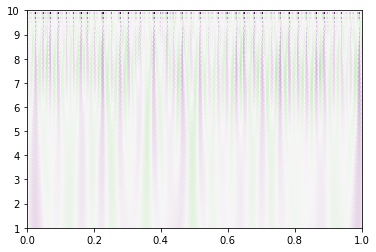

    0         1         2         3         4         5         6         7   \
0  0.0 -2.760350  0.560051 -1.608715  0.288481 -1.224891 -0.320248 -1.016527   
1  0.0 -0.138017  0.097126  0.013511  0.108068  0.555873  0.337916  0.410651   
2  0.0 -0.448557  0.227905 -0.238254  0.181291 -0.004423 -0.045727  0.158872   
3  0.0 -0.897114  0.256000 -0.498883  0.172527 -0.223618 -0.012648 -0.155687   
4  0.0 -0.517566  0.246766 -0.254594  0.197977  0.109651 -0.001060  0.095696   

         8         9     ...           90        91        92        93  \
0 -0.512363 -0.864797    ...     0.001644  0.051833 -0.004348  0.046060   
1  0.491892  0.133148    ...    -0.107114 -0.055515 -0.113238 -0.061490   
2 -0.030263  0.310198    ...    -0.216643 -0.165078 -0.222593 -0.170938   
3 -0.042468 -0.096497    ...    -0.323587 -0.273608 -0.329111 -0.279086   
4 -0.055597 -0.016158    ...    -0.424499 -0.377719 -0.429432 -0.382625   

         94        95        96        97        98        99  
0 -0

In [79]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

sig = singles['talented']['voltage']
widths = np.linspace(0.001,10,100)
wt_out = signal.cwt(sig, signal.ricker, widths)
print (wt_out, wt_out.shape)
plt.imshow(wt_out, extent=[0, 1, 1, 10],cmap='PRGn',aspect='auto',vmax=abs(wt_out).max(), vmin=-abs(wt_out).max())
plt.show()
wt_out_frame = pandas.DataFrame(wt_out).T
print(wt_out_frame.head())

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.21761699  0.19510715  0.34282162 ...,  0.05530214  0.2115246
   0.19452989]
 [ 0.06112065  0.15754708  0.18022451 ...,  0.15502257  0.12210043
   0.00117739]
 ..., 
 [ 0.15203933  0.05455397 -0.04674396 ..., -0.39015015 -0.30638233
  -0.21319804]
 [ 0.14901181  0.0518654  -0.04894284 ..., -0.38906269 -0.30589099
  -0.21367598]
 [ 0.14590573  0.04911748 -0.05117597 ..., -0.38786557 -0.30536787
  -0.21416483]] (50, 443) (443,)


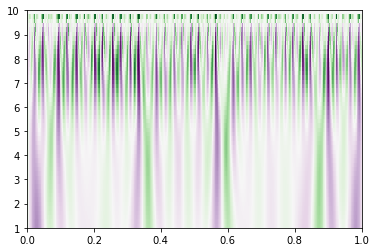

In [62]:
sig2 = singles['stereotyped']['voltage']
# widths = np.linspace(0.005,10)
wt_out2 = signal.cwt(sig2, signal.ricker, widths)
print (wt_out2, wt_out2.shape, sig2.shape)
plt.imshow(wt_out2, extent=[0, 1, 1, 10],cmap='PRGn',aspect='auto',vmax=abs(wt_out2).max(), vmin=-abs(wt_out2).max())
plt.show()

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.25225952  0.31789617  0.35013249 ..., -0.05106942  0.10697012
   0.15562391]
 [ 0.0916119   0.25124769  0.10823091 ...,  0.04766228  0.09560003
  -0.00289261]
 ..., 
 [-0.24321081 -0.35800353 -0.46378681 ...,  0.03324018  0.1366627
   0.23934907]
 [-0.24325612 -0.35707026 -0.46211714 ...,  0.03807079  0.14039604
   0.2418738 ]
 [-0.24308499 -0.35583004 -0.46009478 ...,  0.04253891  0.14392721
   0.24434925]] (50, 642) (642,)


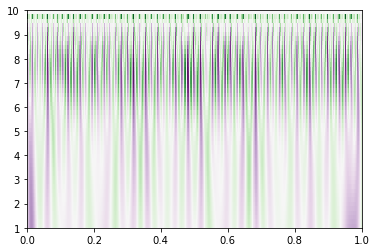

In [63]:
sig3 = singles['weather']['voltage']
# widths = np.linspace(0.005,10)
wt_out3 = signal.cwt(sig3, signal.ricker, widths)
print (wt_out3, wt_out3.shape, sig3.shape)
plt.imshow(wt_out3, extent=[0, 1, 1, 10],cmap='PRGn',aspect='auto',vmax=abs(wt_out3).max(), vmin=-abs(wt_out3).max())
plt.show()